
# Face recognition with Transfer Leraning

In [1]:
import cv2

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

In [4]:
from keras.preprocessing import image

In [5]:
from keras.applications import vgg16

In [6]:
#img_rows, img_cols=224,224
img_rows, img_cols=200,200

In [7]:
model=vgg16.VGG16(weights='imagenet', include_top = False,
                 input_shape = (img_rows, img_cols, 3))

In [8]:
model.layers

In [9]:
for (i,layer) in enumerate(model.layers):
    print(str(i)+"  "+model.layers[0].__class__.__name__+"  "+str(model.layers[i].trainable))

0  InputLayer  True
1  InputLayer  True
2  InputLayer  True
3  InputLayer  True
4  InputLayer  True
5  InputLayer  True
6  InputLayer  True
7  InputLayer  True
8  InputLayer  True
9  InputLayer  True
10  InputLayer  True
11  InputLayer  True
12  InputLayer  True
13  InputLayer  True
14  InputLayer  True
15  InputLayer  True
16  InputLayer  True
17  InputLayer  True
18  InputLayer  True


In [10]:
model.layers[0].input

<tf.Tensor 'input_1:0' shape=(None, 200, 200, 3) dtype=float32>

In [11]:
for layer in model.layers:
    layer.trainable = False

In [12]:
def addToModel(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 4

FC_Head = addToModel(model, num_classes)

new_model = Model(inputs = model.input, outputs = FC_Head)

print(new_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

In [14]:
from keras.preprocessing.image import ImageDataGenerator

#train_data_dir = 'C:/temp/5016ProjectData_OpenCV/train/'
#validation_data_dir = 'C:/temp/5016ProjectData_OpenCV/validate/'


train_data_dir = r'C:\Users\Paddy\Google Drive (paddykcc@gmail.com)\5016Project\FaceRecognition\image\train'
validation_data_dir = r'C:\Users\Paddy\Google Drive (paddykcc@gmail.com)\5016Project\FaceRecognition\image\validate'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
#batch_size = 12

batch_size = 10
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [15]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
                   
checkpoint = ModelCheckpoint("facedetect.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate 
new_model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

#nb_train_samples = 1190
#nb_validation_samples = 170

nb_train_samples = 310
nb_validation_samples = 310

epochs = 3
#batch_size = 16

batch_size = 10

#history = new_model.fit_generator(
history = new_model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

new_model.save("facedetect.h5")

Epoch 1/3
31/31 [==============================] - ETA: 0s - loss: 5.3315 - accuracy: 0.5323
Epoch 00001: val_loss improved from inf to 0.94925, saving model to facedetect.h5
31/31 [==============================] - 91s 3s/step - loss: 5.3315 - accuracy: 0.5323 - val_loss: 0.9493 - val_accuracy: 0.4806
Epoch 2/3
31/31 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9645
Epoch 00002: val_loss improved from 0.94925 to 0.00004, saving model to facedetect.h5
31/31 [==============================] - 93s 3s/step - loss: 0.0928 - accuracy: 0.9645 - val_loss: 4.3653e-05 - val_accuracy: 1.0000
Epoch 3/3
31/31 [==============================] - ETA: 0s - loss: 1.9346e-04 - accuracy: 1.0000
Epoch 00003: val_loss did not improve from 0.00004
31/31 [==============================] - 90s 3s/step - loss: 1.9346e-04 - accuracy: 1.0000 - val_loss: 1.7790 - val_accuracy: 0.7548


In [16]:
train_generator.class_indices

{'Lydia': 0, 'Others': 1, 'Paddy': 2, 'Venus': 3}

In [17]:
validation_generator.class_indices

{'Lydia': 0, 'Others': 1, 'Paddy': 2, 'Venus': 3}

### TESTING

In [45]:
from keras.models import load_model

In [46]:
m= load_model('facedetect.h5')

In [47]:
from keras.preprocessing import image

In [48]:
path = r'C:\Users\Paddy\Google Drive (paddykcc@gmail.com)\5016Project\FaceRecognition\image\test\test.jpg'
timage= image.load_img(path)

In [49]:
type(timage)

PIL.JpegImagePlugin.JpegImageFile

In [50]:
type(timage)

PIL.JpegImagePlugin.JpegImageFile

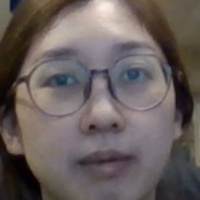

In [51]:
timage

In [52]:
timage= image.img_to_array(timage)

In [53]:
timg= np.expand_dims(timage,axis=0)

In [54]:
timg.shape

(1, 200, 200, 3)

In [55]:
result = m.predict(timg)

In [56]:
result

array([[0., 0., 0., 1.]], dtype=float32)

In [57]:
# Generate arg maxes for predictions
classes = np.argmax(result, axis = 1)
print(classes)

[3]


In [31]:
# Convert the h5 to TFLite model

#My_TFlite_Model = tf.keras.models.load_model('facedetect.h5')

#converter = tf.lite.TFLiteConverter.from_keras_model(minor_model)

#tflite_model = converter.convert()

#open("facedetect.tflite","wb").write(tflite_model)